## This notebook contains a series 

##### Attributes:

### Weather:
- Station
- Tavg
- PrecipTotal
- StnPressure
- SeaLevel
- ResultSpeed
- ResultDir


## Notebook Contents
- [Grouping countries & dataframe subsets](#location)
- [regression 1](#reg_1)
- [regression 2](#reg_2)
- [regression 3](#reg_3)
- [regression 4](#reg_4)
- [Summary of outputs](#summary)

Further analysis of these models and comparisons to other models can be found in the [Model Comparison notebook](https://github.com/sonyah-hawaii/time_series_regressive_modeling/blob/master/Model%20Comparison.ipynb)

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [29]:
abatement_historical = pd.read_csv('./Data/abatement_calculations.csv')

In [30]:
abatement_historical.set_index('country', inplace=True)
abatement_historical = abatement_historical

## Grouping countries for models
## Creating datasets for groups
- regression 1: cluster 1
    - (Algeria, Argentina, Australia, Belgium, Chile, France, Indonesia, Italy, Kazakhstan, Kuwait, Malaysia, Mexico, Netherlands, New Zealand, Nigeria, Poland, Portugal, Romania, Saudi Arabia, South Africa, Spain, Sweden, Thailand, Turkey, Ukraine, United Arab Emirates, United Kingdom, Uzbekistan)
- regression 2: cluster 2
    - (Norway)
- regression 3: clusters 0, 3, 4
    - (US, China, Brazil)
- regression 4: cluster 5
    - (Canada, Colombia, Germany, India, Japan)

In [31]:
regression_1 = abatement_historical[abatement_historical.label==1]
regression_2 = abatement_historical[abatement_historical.label==2]
regression_3 = abatement_historical.loc[(abatement_historical.label==0)
                                         |(abatement_historical.label==3)
                                        |(abatement_historical.label==4)]
regression_4 = abatement_historical[abatement_historical.label==5]

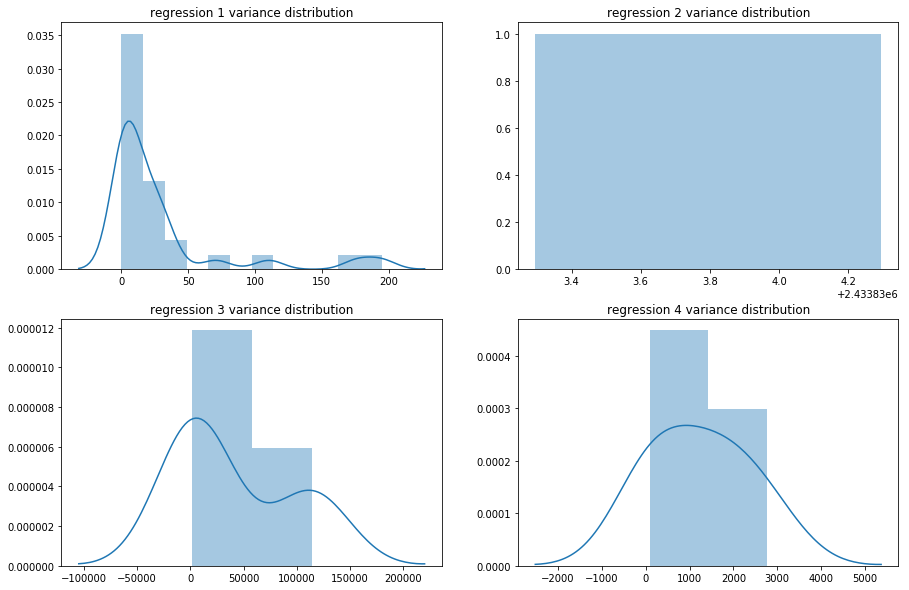

In [63]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.distplot(regression_1.drop('label', axis=1).T.var());
plt.title('regression 1 variance distribution');

plt.subplot(2,2,2)
sns.distplot(regression_2.drop('label', axis=1).T.var());
plt.title('regression 2 variance distribution');

plt.subplot(2,2,3)
sns.distplot(regression_3.drop('label', axis=1).T.var());
plt.title('regression 3 variance distribution');

plt.subplot(2,2,4)
sns.distplot(regression_4.drop('label', axis=1).T.var());
plt.title('regression 4 variance distribution');

### ARIMA

- build a dataframe where features are lagged timepoints
- target is the next feature in the progression  
  
- specify priors on all coefficients
- specify priors on variance of data
- plug things into the model 
- follow pymc3 lesson

- goal is actually a posterior predictive
- pyflux provides uncertainty bounds (UL + LL)
- for a highly generalized bayesian regression try pymc3
    - you  need to specify priors and distributions
    - begin with something relatively uninformative (broad gaussian, uniform, etc.) 
    
1. write out an equation, which model inteded (ex. regression + variance)
2. specify priors for each coefficient, prior on variance
    - pymc3 this means creating new objects 
3. take existing objects/variables that contain priors and build a likelihood distribution with observed data
    - prior variables act as parameters
    - MCMC
4. estimate y-hat and save values
    - this is where we capture variance
    - write out a function to pull samples from these distributions
    - codify the samples pulled, **construct a distribution of y-hat** fitting to obtain bounds and represent uncertainty or anticipated variance
        - we can use this to set a confidence interval
    - combining these observations to understand uncertainty is where this gets shaky

In [14]:
abatement_time_series = abatement_historical.T

In [21]:
abatement_time_series.columns = abatement_time_series.iloc[0,:]
abatement_time_series.drop('country', inplace=True)

In [22]:
abatement_time_series

country,Algeria,Argentina,Australia,Belgium,Brazil,Canada,Chile,China,Colombia,France,...,South Africa,Spain,Sweden,Thailand,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States,Uzbekistan
1990,0.202225,19.9962,16.0302,0.511173,498.823,233.588,12.6144,197.209,41.6759,10.4974,...,3.13409,17.1074,9.44513,3.90868,26.8465,11.9388,0,6.27589,297.694,6.37842
1991,0.423816,17.4816,17.5863,0.554798,508.579,224.064,20.9216,190.067,41.0019,12.1646,...,4.164,18.3134,8.28154,3.73366,24.2177,13.1512,0,5.40814,281.18,5.97541
1992,0.279782,21.8484,17.0252,0.60915,519.889,237.567,34.7957,197.754,30.3603,12.3338,...,2.28446,14.1979,9.71518,3.23994,28.4644,8.2606,0,6.48559,270.727,6.84418
1993,0.473316,22.734,18.0926,0.55569,627.473,225.734,32.9561,229.011,39.5106,9.05038,...,1.61832,15.8853,10.685,2.72693,37.1139,12.5394,0,5.2004,294.003,8.65137
1994,0.215557,25.0232,17.3497,0.661508,645.963,221.349,27.3786,251.581,44.7805,10.8064,...,2.80282,18.5013,8.05858,3.33916,32.1434,13.3554,0,6.08559,275.966,7.80651
1995,0.264797,23.8593,16.8152,0.701022,522.499,234.694,27.1268,286.52,44.6299,10.7273,...,2.0452,16.6226,8.96479,5.13921,36.2946,10.9875,0,5.81574,314.143,5.78622
1996,0.17252,19.3271,17.2085,0.664418,506.651,259.831,21.803,291.545,57.9613,10.0215,...,3.93633,25.7424,8.40598,6.15845,42.1715,7.9139,0,4.85778,350.482,6.99713
1997,0.0999734,24.5348,18.7014,0.625552,515.553,273.579,26.6828,290.374,36.8575,9.1448,...,5.32608,23.0702,9.31378,5.80353,39.3925,8.65799,0,5.36198,346.379,6.00027
1998,0.26495,22.4641,18.0363,0.742884,523.203,273.651,17.9683,313.398,38.9187,11.2377,...,4.93976,22.6857,10.2419,4.20279,41.9694,14.1784,0,6.44782,307.657,6.30412
1999,0.254168,16.5947,18.708,0.711241,420.832,285.768,13.8256,291.839,50.543,11.8364,...,3.95366,18.4246,8.72065,3.33142,30.5948,12.6787,0,7.82732,285.949,6.25046
